In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import Swaptionvol
import SABRnormal

# Import data from file and order it
datafile = pd.read_excel('Invertir_Smile_Mercado_Swaption.xlsx')
FS = datafile.iloc[22,2]
Premium_put = datafile.iloc[10,4:11].values/10000
Premium_call = datafile.iloc[10,11:17].values/10000
K_put = datafile.iloc[11,4:11].values;
K_call = datafile.iloc[11,11:17].values;
K = np.concatenate((np.hstack(K_put),np.hstack(K_call)),axis=None)
Annuity = datafile.iloc[20,2]; Expiry = datafile.iloc[5,4]
ATMstrike = K[np.nonzero(K == FS)]

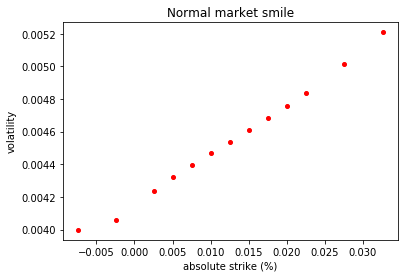

In [6]:
# Implied market Normal volatilies
sigmacall = []; sigmaput = [];
for i in range(K_call.size):
    sigmacall.append(Swaptionvol.SwaptionNormalvol(FS,K_call[i],Annuity,Expiry,Premium_call[i],1))
for j in range(K_put.size):
    sigmaput.append(Swaptionvol.SwaptionNormalvol(FS,K_put[j],Annuity,Expiry,Premium_put[j],-1))
sigmaMKT = np.asarray(sigmaput + sigmacall)
plt.plot(K,sigmaMKT,'ro',markersize=4); plt.title('Normal market smile');
plt.ylabel("volatility"); plt.xlabel("absolute strike (%)");

In [7]:
def SABRplot(K,FS,X,sigmaMKT,estvol,title):
    plt.figure()        #creates new figure
    plt.plot(K,sigmaMKT,'rx',label='Market vols')
    plt.plot(X,estvol,label='Fitted vols')
    plt.title(title); plt.ylabel('volatility'); plt.xlabel("strike (bp)");
    plt.scatter(K[np.nonzero(K == FS)],sigmaMKT[np.nonzero(K == FS)],c="black",marker='o',label='ATM vol') #ATM
    plt.gca().set_yticklabels(['{:.2f}%'.format(x*100) for x in plt.gca().get_yticks()]) #vol as %
    plt.gca().set_xticklabels(['{:.0f}'.format(x*10000) for x in plt.gca().get_xticks()]) #vol as %
    plt.legend();

# Calibración por el primer método

[alpha, rho, nu] =  [0.00660456 0.45580823 0.08538232]


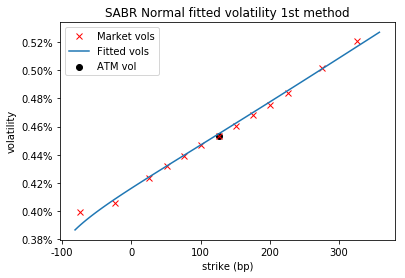

In [8]:
# calibra el modelo
beta = 0.1; shift = 0.01; seed = [0.004,0.5,0.2]
param1 = SABRnormal.calibrate(K,FS,Expiry, beta, shift, sigmaMKT, seed)
alpha = param1[0]; rho = param1[1]; nu = param1[2]; estvol1 = []
# representación de la parametrización
X = np.arange(min(K)*1.1, max(K)*1.1, (max(K)-min(K))/100)
for i in range(len(X)):
    aux = SABRnormal.normal_vol(X[i],FS,Expiry,alpha,beta,rho,nu,shift)
    estvol1.append(aux)

title = 'SABR Normal fitted volatility 1st method' 
SABRplot(K,FS,X,sigmaMKT,estvol1,title)
print('[alpha, rho, nu] = ',param1)

# Calibración por el segundo método

[alpha, rho, nu] =  [0.00656883414717314, 0.4197432202989268, 0.09514000696234337]


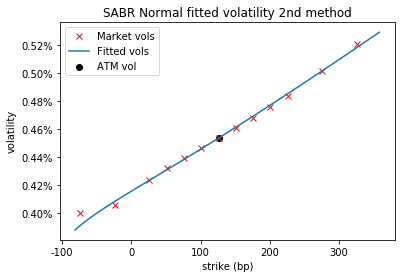

In [9]:
beta = 0.1; shift = 0.01; seed = [0.5,0.4]
param2 = SABRnormal.calibrate2(K,FS,Expiry, beta, shift, sigmaMKT, seed)

# representación de la parametrización
X = np.arange(min(K)*1.1, max(K)*1.1, (max(K)-min(K))/100); estvol2 = []

for i in range(len(X)):
    aux = SABRnormal.normal_vol(X[i],FS,Expiry,param2[0],beta,param2[1],param2[2],shift)
    estvol2.append(aux)

title = 'SABR Normal fitted volatility 2nd method'   
SABRplot(K,FS,X,sigmaMKT,estvol2,title)
print('[alpha, rho, nu] = ',param2)